<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase2/Experiments/BERT2SVM_4SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.5 MB/s eta 0:00:00


In [3]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast, TFAutoModel
import datasets

# gptModel = 'raygx/GPT-NepSA-T2' ## Fine-tuned Model ## 'raygx/Nepali-GPT2-CausalLM' ## Pre-Trained LM ##
# gptTokenizer = PreTrainedTokenizerFast.from_pretrained(gptModel,padding_side='left')
# gptModel = TFAutoModel.from_pretrained(gptModel)

bertModel = 'raygx/BERT-NepSA-T2' ## Fine-tuned Model for SA ## 'raygx/BertClassifier4NepaliNews' ## Fine-tuned Model for NewsClassification ## 'Shushant/nepaliBERT' ## Pre-Trained LM ##
bertTokenizer = BertTokenizerFast.from_pretrained(bertModel)
try:
  bertModel = TFAutoModel.from_pretrained(bertModel)
except:
  bertModel = TFAutoModel.from_pretrained(bertModel,from_pt=True)

bertModel.config

Some layers from the model checkpoint at raygx/BERT-NepSA-T2 were not used when initializing TFBertModel: ['classifier', 'dropout_37']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at raygx/BERT-NepSA-T2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


BertConfig {
  "_name_or_path": "raygx/BERT-NepSA-T2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.31.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [4]:
print("#######################Using NepCov19Tweets#########################")
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

#######################Using NepCov19Tweets#########################


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/41541 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/raygx___parquet/raygx--NepCov19TweetsPlus-46f98dd56864ead2/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [5]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [6]:
def prepareLabels(row):
    if row['label'] == -1:
        row['label'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

data

Map (num_proc=4):   0%|          | 0/33232 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/8309 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [7]:
import tensorflow as tf

# class GPTEmbedding(tf.keras.layers.Layer):
#   def __init__(self, model,tokenizer, max_token_len=128,padding='max_length', trailing_context=4,truncation=True):
#     super().__init__()
#     self.embedding = model
#     self.tokenizer = tokenizer
#     self.tokenizer.padding_side = 'left'
#     self.max_token = max_token_len
#     self.padding = padding
#     self.truncation = truncation
#     self.trailing_context = trailing_context
#     self.trainable=False

#   def call(self, x):
#     embeddings = self.embedding(
#                   self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf')
#                 )[0][:,-self.trailing_context:,:]

#     return tf.reduce_logsumexp(embeddings,axis=1)

class BERTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trainable=False

  def call(self, x):
    return self.embedding(self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf'))[1]

### Preparing Training Data

In [8]:
from tqdm.auto import tqdm

# gptEmbd = GPTEmbedding(model=gptModel,tokenizer=gptTokenizer,trailing_context=4,max_token_len=100)
bertEmbd = BERTEmbedding(model=bertModel,tokenizer=bertTokenizer,max_token_len=100)

X = None
batch = 32
for i in tqdm(range(0,data['train'].num_rows,batch)):
    feat = bertEmbd(data['train'][i:i+batch]['text'])

    if i==0:
        X = feat
    else:
        X = np.concatenate([X,feat],axis=0)

X.shape

  0%|          | 0/1039 [00:00<?, ?it/s]

(33232, 768)

In [9]:
### Attention Visualization
# import seaborn as sns

# output = bertModel(bertTokenizer(data['train'][:1]['text'],return_tensors='tf'),output_attentions=True)
# print(output.keys())
# print(output['attentions'][1].shape)

### output['attentions'][nLayer][nBatch][nHead]
# sns.heatmap(output['attentions'][-2][0][-6])

## Training

In [10]:
%%time
from sklearn import svm

y = data['train']['label']
clf = svm.SVC()  ## default 'rbf'
clf.fit(X, y)
clf.classes_

CPU times: user 5min 42s, sys: 677 ms, total: 5min 43s
Wall time: 5min 43s


array([0, 1, 2])

### Preparing Test Data

In [11]:
testX = None
for i in tqdm(range(0,data['test'].num_rows,batch)):
    feat = bertEmbd(data['test'][i:i+batch]['text'])

    if i==0:
        testX = feat
    else:
        testX = np.concatenate([testX,feat],axis=0)

  0%|          | 0/260 [00:00<?, ?it/s]

## Evaluation

In [12]:
%%time
predictions = clf.predict(testX)

CPU times: user 1min 32s, sys: 156 ms, total: 1min 32s
Wall time: 1min 32s


In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y = data['test']['label']
print("F1-Score",f1_score(np.array(y),predictions,average='weighted'))
print("Precision-Score",precision_score(np.array(y),predictions,average='weighted'))
print("Recall-Score",recall_score(np.array(y),predictions,average='weighted'))
print("accuracy_Score",accuracy_score(np.array(y),predictions))

F1-Score 0.8393300150200717
Precision-Score 0.8429876964717282
Recall-Score 0.8389697917920327
accuracy_Score 0.8389697917920327


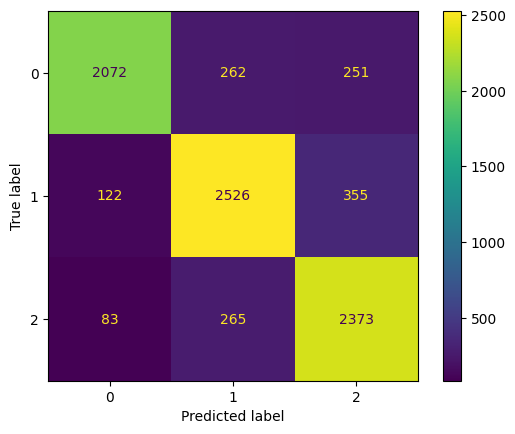

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(np.array(y),predictions,num_classes=3).numpy())
cmd.plot()